In [1]:
import sys
import os
sys.path.append("../")

In [2]:

import warnings
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from IPython.display import clear_output
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import numpy as np
from oodeel.datasets import OODDataset
from oodeel.utils.torch_training_tools import train_torch_model

from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features
from methods import Dknn, Vim, energy, entropy, mahalanobis, Mls, Odin, Gram, kmeans, pca_knn, pca_mahalanobis, nmf_knn, nmf_mahalanobis, pca_per_class, nmf_per_class, pca_per_class_mahalanobis, nmf_per_class_mahalanobis



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model_path = "../../models/MNIST"
data_path = os.path.expanduser("~/") + "../../data/MNIST/"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

In [4]:
backend = "torch"

oods_in = OODDataset(
    'MNIST', 
    load_kwargs = {"train": False, "root": data_path, "download": True}, 
    backend=backend,
)
oods_out = OODDataset(
    'FashionMNIST', 
    load_kwargs = {"train": False, "root": data_path, "download": True}, 
    backend=backend,
)
oods_train = OODDataset(
    'MNIST', 
    load_kwargs = {"train": True, "root": data_path, "download": True}, 
    backend=backend,
)


def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))

batch_size = 128

ds_in = oods_in.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_train = oods_train.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)

model_path_mnist = os.path.join(model_path, "mnist_model_torch")
try:
    model = torch.load(os.path.join(model_path_mnist, "best.pt"))
except OSError:
    train_config = {
        "model": "toy_convnet",
        "num_classes": 10,
        "epochs": 5,
        "save_dir": model_path_mnist,
        "validation_data": ds_in, #ds_in is actually the test set of MNIST
        "cuda_idx": 0
    }
    model = train_torch_model(ds_train,  **train_config)


In [5]:
# # initilize the pretrained model
# model = load_pretrained_weights_32(dataset='CIFAR-100', model_version='s0', num_classes=100)
# model.to("cuda")
# print(model)

Test accuracy:	0.987300

=== Penultimate features viz ===


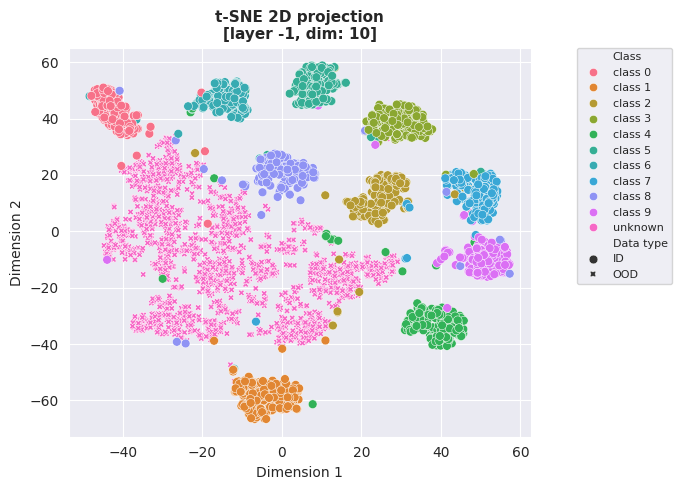

In [6]:
# evaluating thee model on test data to see test accuracy
model.eval()
labels, preds = [], []
for x, y in ds_in:
    x = x.to("cuda")
    # y = y.to("cuda")
    preds.append(torch.argmax(model(x), dim=-1).detach().cpu())
    labels.append(y)
print(f"Test accuracy:\t{accuracy_score(torch.cat(labels), torch.cat(preds)):.6f}")

# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(7, 5))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-1,
)
plt.tight_layout()
plt.show()

In [7]:
# model.to("cuda")

# GRAM Method

=== Metrics ===
auroc      0.930390
fpr95tpr   0.403700

=== Plots ===


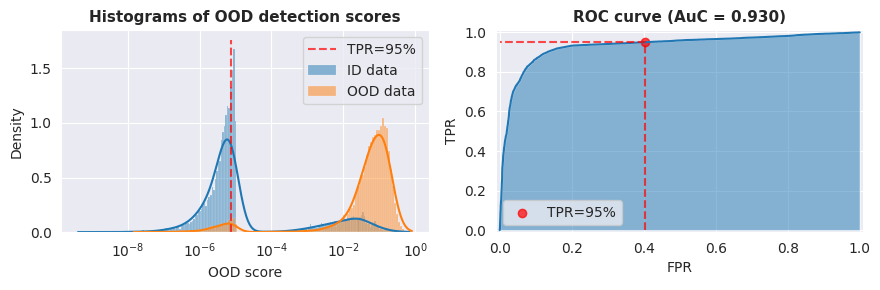

In [8]:
model.to("cpu")
for x , y in ds_in:
    x = x.to("cpu")
    y = y.to("cpu")

for x , y in ds_out:
    x = x.to("cpu")
    y = y.to("cpu")

for x , y in ds_train:
    x = x.to("cpu")
    y = y.to("cpu")

Gram.fit(model, ds_train, feature_layers_id=[-1])
scores_in, _ = Gram.score(ds_in)
scores_out, _ = Gram.score(ds_out)


# Since many scores are equal to 0, we add a random noise to avoid bugs
# in Auroc and TPR computation.
scores_in += np.random.random_sample(size=scores_in.shape) * 10e-6
scores_out += np.random.random_sample(size=scores_out.shape) * 10e-6

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")


print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=True)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

model.to("cuda")
for x , y in ds_in:
    x = x.to("cuda")
    y = y.to("cuda")

for x , y in ds_out:
    x = x.to("cuda")
    y = y.to("cuda")

for x , y in ds_train:
    x = x.to("cuda")
    y = y.to("cuda")


# MLS Method

=== Metrics ===
auroc      0.993097
fpr95tpr   0.024700

=== Plots ===


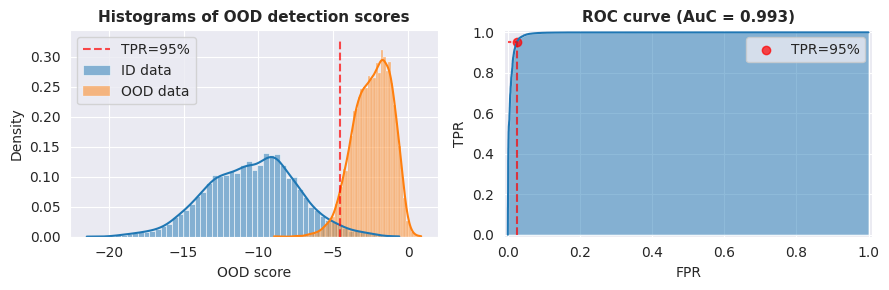

In [9]:
# === mls scores ===
Mls.fit(model)
scores_in, _ = Mls.score(ds_in)
scores_out, _ = Mls.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# ODIN Method

=== Metrics ===
auroc      0.993324
fpr95tpr   0.026000

=== Plots ===


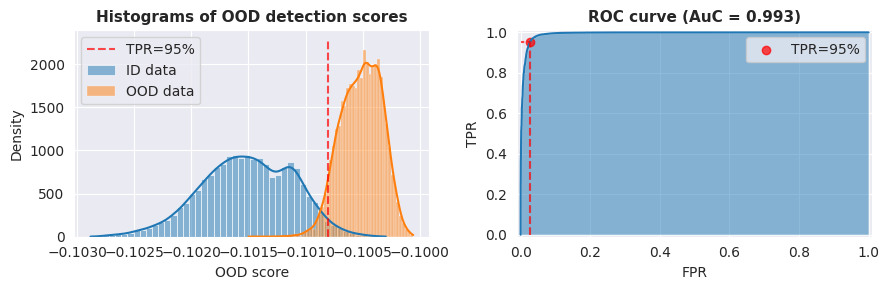

In [10]:
# === odin scores ===

Odin.fit(model)
scores_in, _ = Odin.score(ds_in)
scores_out, _ = Odin.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# DKNN Method

=== Metrics ===
auroc      0.968877
fpr95tpr   0.135400

=== Plots ===


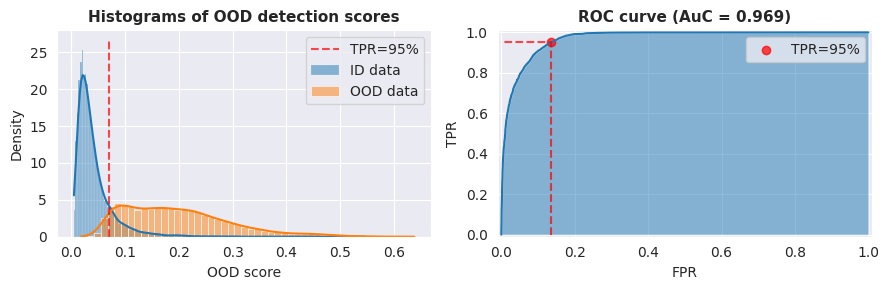

In [11]:
# === dknn scores ===
Dknn.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)
scores_in, _ = Dknn.score(ds_in)
scores_out, _ = Dknn.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# VIM Method

=== Metrics ===
auroc      0.951114
fpr95tpr   0.184800

=== Plots ===


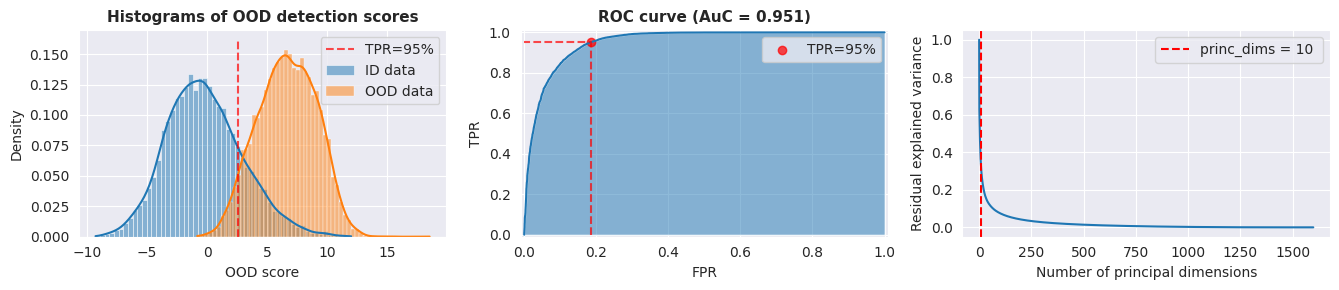

In [12]:
# === vim scores ===
Vim.fit(model, feature_layers_id=[-2], fit_dataset=ds_train)
scores_in, _ = Vim.score(ds_in)
scores_out, _ = Vim.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(13.5, 3))
plt.subplot(131)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(132)
plot_roc_curve(scores_in, scores_out)
plt.subplot(133)
Vim.plot_spectrum()
plt.tight_layout()
plt.show()

# Energy Method

=== Metrics ===
auroc      0.993325
fpr95tpr   0.024100

=== Plots ===


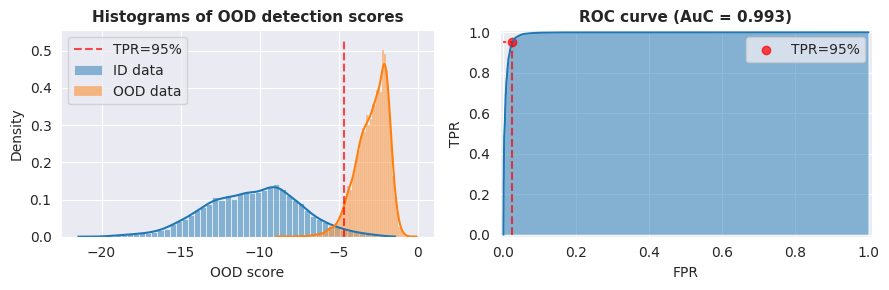

In [13]:
# === energy scores ===
energy.fit(model)
scores_in, _ = energy.score(ds_in)
scores_out, _ = energy.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# Entropy Method

=== Metrics ===
auroc      0.985204
fpr95tpr   0.057400

=== Plots ===


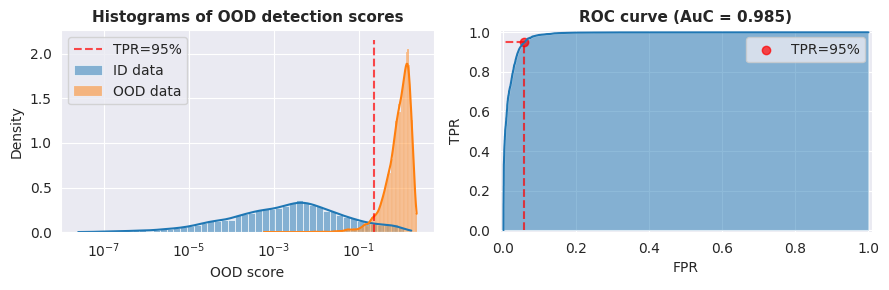

In [14]:
# === Entropy scores ===
entropy.fit(model)
scores_in, _ = entropy.score(ds_in)
scores_out, _ = entropy.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=True)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# Mahalanobis Method

=== Metrics ===
auroc      0.874311
fpr95tpr   0.465200

=== Plots ===


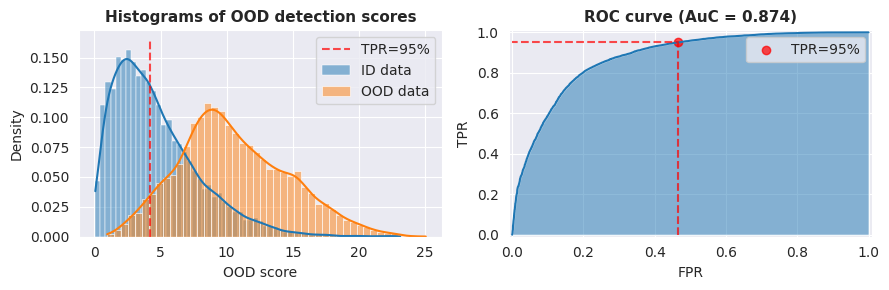

In [15]:
# === mahalanobis scores ===
mahalanobis.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)
scores_in, _ = mahalanobis.score(ds_in)
scores_out, _ = mahalanobis.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# K-MEANS Method

Performing K-means clustering...
K-means clustering Done...
#------------------------------------------------------------
=== Metrics ===
auroc      0.709056
fpr95tpr   0.629300

=== Plots ===


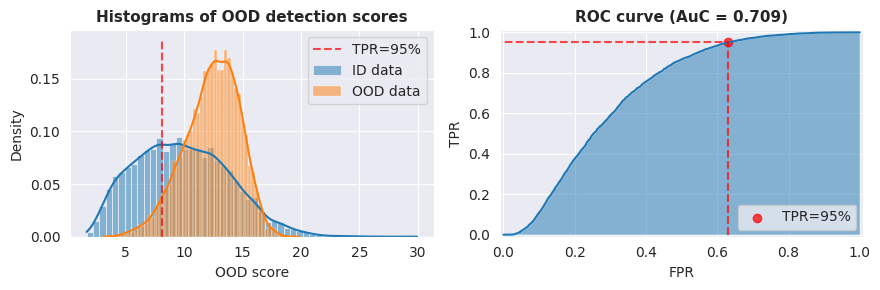

In [16]:
kmeans.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)

scores_in, _ = kmeans.score(ds_in)
scores_out, _ = kmeans.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# PCA - K-nearest-Neighbor

the shape of W_train is  :  (60000, 9)
the shape of H_base is  :  (9, 10)
=== Metrics ===
auroc      0.822947
fpr95tpr   0.484000

=== Plots ===


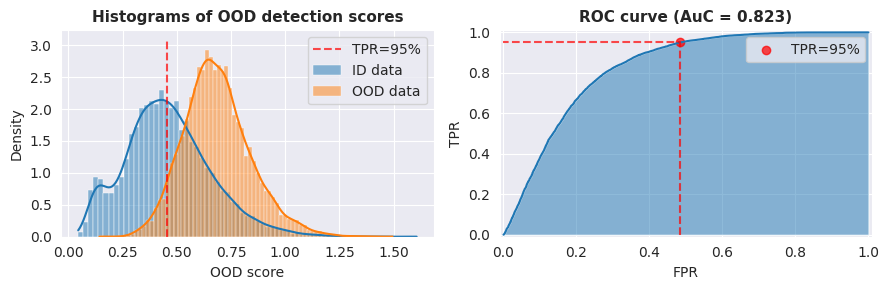

In [17]:
pca_knn.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)

scores_in, _ = pca_knn.score(ds_in)
scores_out, _ = pca_knn.score(ds_out)


# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# PCA - Mahalanobis Method

the shape of W_train is  :  (60000, 9)
the shape of H_base is  :  (9, 10)
done fitting ...
done score_in ...
done score_out ...
=== Metrics ===
auroc      0.871870
fpr95tpr   0.560400

=== Plots ===


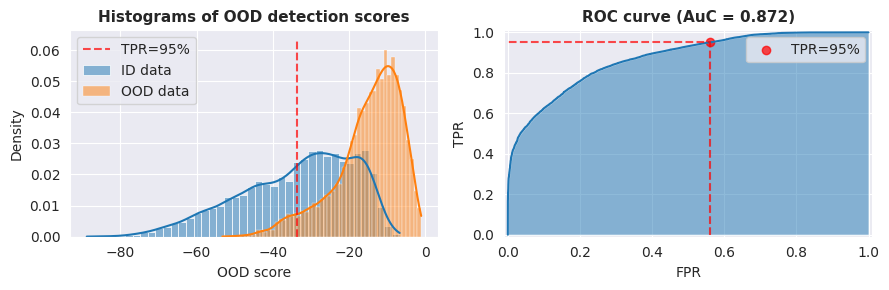

In [18]:
pca_mahalanobis.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)
print("done fitting ...")
scores_in, _ = pca_mahalanobis.score(ds_in)
print("done score_in ...")

scores_out, _ = pca_mahalanobis.score(ds_out)
print("done score_out ...")

scores_in = np.negative(scores_in)
scores_out = np.negative(scores_out)
# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# NMF - K-nearest-neghbor Method

the shape of H_base is :  (9, 10)
the shape of W_train is  :  (60000, 9)
=== Metrics ===
auroc      0.999969
fpr95tpr   0.000100

=== Plots ===


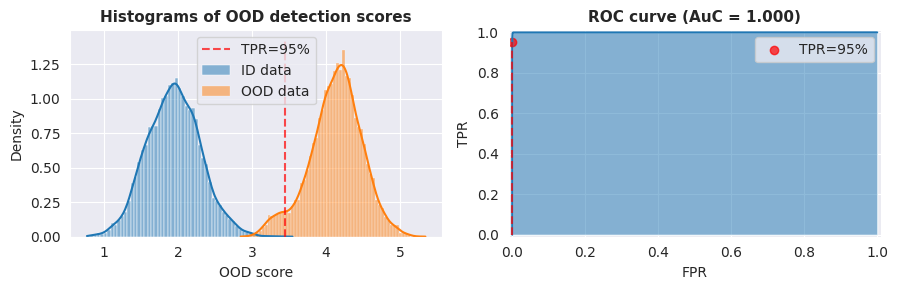

In [19]:
nmf_knn.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)

scores_in, _ = nmf_knn.score(ds_in)
scores_out, _ = nmf_knn.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# NMF - Mahalanobis Method

the shape of H_base is :  (9, 10)
the shape of W_train is  :  (60000, 9)
done fitting ...
done score_in ...
done score_out ...
=== Metrics ===
auroc      0.886585
fpr95tpr   0.420400

=== Plots ===


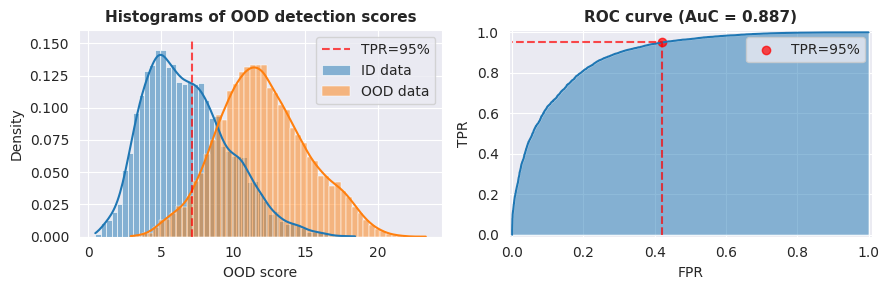

In [20]:
nmf_mahalanobis.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)
print("done fitting ...")

scores_in, _ = nmf_mahalanobis.score(ds_in)
print("done score_in ...")

scores_out, _ = nmf_mahalanobis.score(ds_out)
print("done score_out ...")


# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# PCA per class

done fitting ...
done score in ...
done score out ...
=== Metrics ===
auroc      0.838619
fpr95tpr   0.455700

=== Plots ===


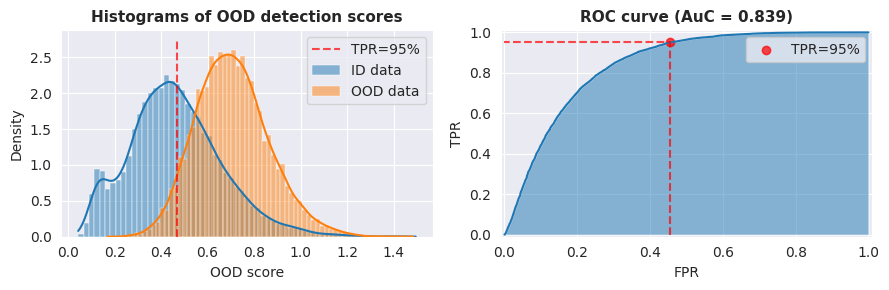

In [6]:
# === PCA per class scores ===

pca_per_class.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)
print("done fitting ...")
scores_in, _ = pca_per_class.score(ds_in)
print("done score in ...")
scores_out, _ = pca_per_class.score(ds_out)
print("done score out ...")

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# NMF per class

done fitting ...
done score in ...
done score out ...
=== Metrics ===
auroc      0.999995
fpr95tpr   0.000000

=== Plots ===


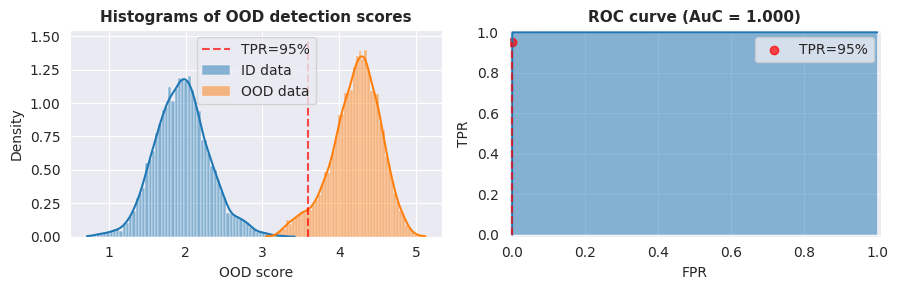

In [7]:
# === NMF per class scores ===

nmf_per_class.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)
print("done fitting ...")
scores_in, _ = nmf_per_class.score(ds_in)
print("done score in ...")
scores_out, _ = nmf_per_class.score(ds_out)
print("done score out ...")

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# PCA per class with mahalanobis


done fitting ...
done score in ...
done score out ...
=== Metrics ===
auroc      0.822536
fpr95tpr   0.447600

=== Plots ===


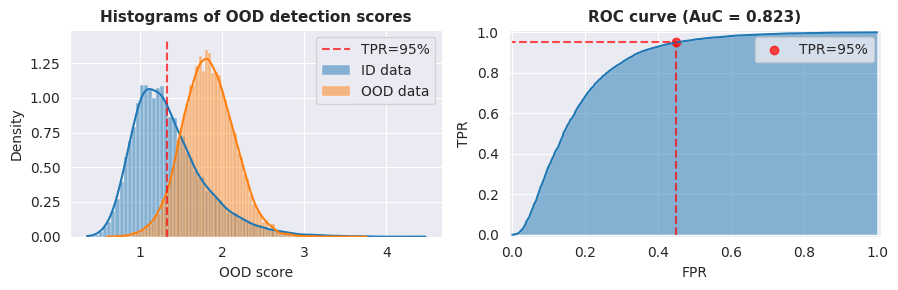

In [8]:
# === PCA per class scores ===

pca_per_class_mahalanobis.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)
print("done fitting ...")
scores_in, _ = pca_per_class_mahalanobis.score(ds_in)
print("done score in ...")
scores_out, _ = pca_per_class_mahalanobis.score(ds_out)
print("done score out ...")

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# NMF per class with mahalanobis

done fitting ...
done score in ...
done score out ...
=== Metrics ===
auroc      0.999999
fpr95tpr   0.000000

=== Plots ===


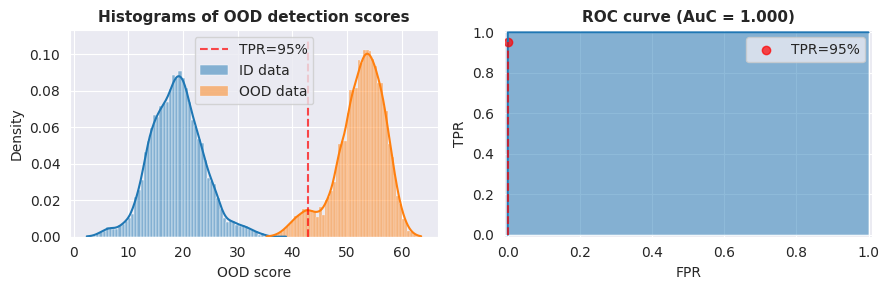

In [9]:
# === NMF per class scores ===

nmf_per_class_mahalanobis.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)
print("done fitting ...")
scores_in, _ = nmf_per_class_mahalanobis.score(ds_in)
print("done score in ...")
scores_out, _ = nmf_per_class_mahalanobis.score(ds_out)
print("done score out ...")

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()
